<a href="https://colab.research.google.com/github/zahrael97/COVID-19-detection-using-deep-Learning/blob/master/InceptionResNetV2/InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Covid Detection using Transfer Learning**

In [0]:
# importing all the required libraries and modules

import numpy as np
import os, random
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Path of various directories
# Dataset : Chest X-Ray Images (Pneumonia) from Kaggle 

TRAIN_DIR = '/content/drive/My Drive/Dataset_Zahra/train'
TEST_DIR = '/content/drive/My Drive/Dataset_Zahra/test'
#VAL_DIR = '/content/drive/My Drive/chest_xray/val'

Covid_train = '/content/drive/My Drive/chest_xray/train/Covid'
normal_train = '/content/drive/My Drive/chest_xray/train/normal'

Covid_test = '/content/drive/My Drive/chest_xray/test/Covid'
normal_test = '/content/drive/My Drive/chest_xray/test/normal'

#pneumonia_val = '/content/drive/My Drive/chest_xray/val/PNEUMONIA'
#normal_val = '/content/drive/My Drive/chest_xray/val/NORMAL'

# **Customizing the Inceptionv3 model**

In [0]:
base_model=InceptionResNetV2(weights='imagenet',include_top=False)
# and slices off the top layer which is the one that classifies objects into various classes (we don't want this layer)

# Setting up the pre-trained weights of the inceptionv3 model as non-trainable
for layer in base_model.layers:
    layer.trainable=False       

# Adding new layers on top of the base model
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation - here, we have only 2 classes (Pneumonia & Normal)

In [119]:
# Specify the inputs
# Specify the outputs
model=Model(inputs=base_model.inputs,outputs=preds)

# A new model has been created based on our architecture
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1828 (Conv2D)            (None, None, None, 3 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1828 (Batch (None, None, None, 3 96          conv2d_1828[0][0]                
__________________________________________________________________________________________________
activation_1828 (Activation)    (None, None, None, 3 0           batch_normalization_1828[0][0]   
___________________________________________________________________________________________

In [120]:
# Name of all the layers in our new model which is built on top of the Inceptionv3 model (look at No. 311 till final layer)
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_10
1 conv2d_1828
2 batch_normalization_1828
3 activation_1828
4 conv2d_1829
5 batch_normalization_1829
6 activation_1829
7 conv2d_1830
8 batch_normalization_1830
9 activation_1830
10 max_pooling2d_37
11 conv2d_1831
12 batch_normalization_1831
13 activation_1831
14 conv2d_1832
15 batch_normalization_1832
16 activation_1832
17 max_pooling2d_38
18 conv2d_1836
19 batch_normalization_1836
20 activation_1836
21 conv2d_1834
22 conv2d_1837
23 batch_normalization_1834
24 batch_normalization_1837
25 activation_1834
26 activation_1837
27 average_pooling2d_10
28 conv2d_1833
29 conv2d_1835
30 conv2d_1838
31 conv2d_1839
32 batch_normalization_1833
33 batch_normalization_1835
34 batch_normalization_1838
35 batch_normalization_1839
36 activation_1833
37 activation_1835
38 activation_1838
39 activation_1839
40 mixed_5b
41 conv2d_1843
42 batch_normalization_1843
43 activation_1843
44 conv2d_1841
45 conv2d_1844
46 batch_normalization_1841
47 batch_normalization_1844
48 activation_1841
49 activati

## **Data Preparation**

In [121]:
def dir_file_count(directory):
  #Total number of files present inside the 'directory'
  return sum([len(files) for r, d, files in os.walk(directory)])

# Configuration parameters 
rescale = 1./255
target_size = (224, 224)
batch_size = 2            #Specifying the batch size
class_mode = 'categorical'

# Augment the training dataset images 
train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator 
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)
# Augment the validation dataset images
#val_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
#val_generator = val_datagen.flow_from_directory(VAL_DIR, 
  #                                              target_size=target_size,
  #                                              class_mode=class_mode,
  #                                              batch_size=dir_file_count(VAL_DIR),
    #                                            shuffle=False)
# Augment the test dataset images
test_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(TEST_DIR),
                                                  shuffle=False)

Found 312 images belonging to 2 classes.
Found 122 images belonging to 2 classes.


# **Training Process of our custom model**

In [122]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# Loss function will be categorical cross entropy
# Evaluation metric will be accuracy

# Start the training
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=30,                                # Specifying the no. of epochs
                              validation_data=test_generator,
                              validation_steps=len(test_generator))

Epoch 1/30
156/156 [==============================] - 32s 205ms/step - loss: 0.6592 - accuracy: 0.7083 - val_loss: 1.8724 - val_accuracy: 0.5082
Epoch 2/30
156/156 [==============================] - 17s 106ms/step - loss: 0.5786 - accuracy: 0.7340 - val_loss: 0.6344 - val_accuracy: 0.5246
Epoch 3/30
156/156 [==============================] - 19s 123ms/step - loss: 0.6016 - accuracy: 0.7083 - val_loss: 0.7127 - val_accuracy: 0.4918
Epoch 4/30
156/156 [==============================] - 19s 124ms/step - loss: 0.5909 - accuracy: 0.6603 - val_loss: 0.6497 - val_accuracy: 0.6803
Epoch 5/30
156/156 [==============================] - 19s 125ms/step - loss: 0.5715 - accuracy: 0.7019 - val_loss: 1.2976 - val_accuracy: 0.6066
Epoch 6/30
156/156 [==============================] - 19s 124ms/step - loss: 0.5243 - accuracy: 0.7308 - val_loss: 0.4621 - val_accuracy: 0.6721
Epoch 7/30
156/156 [==============================] - 19s 124ms/step - loss: 0.5296 - accuracy: 0.7019 - val_loss: 1.1707 - val_ac

# **Evaluation metrics (Performance)**

In [123]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 
confusion = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
print("-"*70)
print("Report")
print("-"*70)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*70)
print("\n\n")

cls_report_print = classification_report(y_true, y_pred, target_names=['covid', 'Normal'])

cls_report = classification_report(y_true, y_pred, target_names=['covid', 'Normal'], output_dict=True)

print("-"*70)
print("covid Prediction")
print("-"*70)
print(cls_report_print)
print("-"*70)

print( confusion)

1/1 [==============================] - 13s 13s/step
----------------------------------------------------------------------
Report
----------------------------------------------------------------------
Precision     : 98.33%
Recall        : 95.16%
F1-Score      : 96.72%
----------------------------------------------------------------------



----------------------------------------------------------------------
covid Prediction
----------------------------------------------------------------------
              precision    recall  f1-score   support

       covid       0.95      0.98      0.97        60
      Normal       0.98      0.95      0.97        62

    accuracy                           0.97       122
   macro avg       0.97      0.97      0.97       122
weighted avg       0.97      0.97      0.97       122

----------------------------------------------------------------------
[[59  1]
 [ 3 59]]


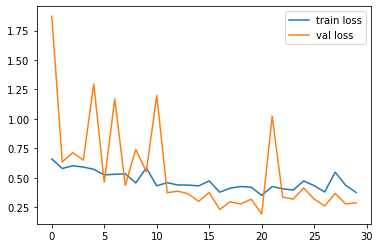

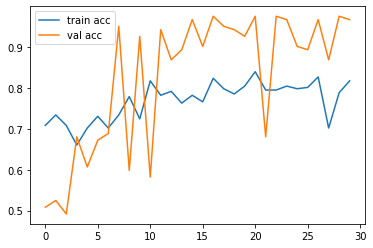

<Figure size 432x288 with 0 Axes>

In [124]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_accuracy')

import tensorflow as tf

from keras.models import load_model

model.save('InceptionV3.h5')